In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import math

from scipy import stats

sns.set_theme()

In [2]:
def read_input(file_path, atleast_2d=False):
    # by default a row of numbers in loaded as a 1D vector
    data = np.loadtxt(file_path)
    if atleast_2d:
        if data.ndim == 1:
            data = data.reshape((1, -1))
    return data

In [3]:
poly_path = "PA-1-data-text/polydata_data_"
X_sample = read_input(f"{poly_path}sampx.txt", atleast_2d=True)
y_sample = read_input(f"{poly_path}sampy.txt")
X_poly = read_input(f"{poly_path}polyx.txt", atleast_2d=True)
y_poly = read_input(f"{poly_path}polyy.txt")

## Part 1: Polynomial function

For this part, we first define a base class for all regression models.

In [4]:
class Regression:
    """Abstract base class for all regression models.

    Suppose a scalar function f(x, θ) with an input x ∈ R^d and an unknown parameter
    θ ∈ R^D has the form
    
        f(x, θ) = ϕ(x)^T θ,
    
    where ϕ: R^d → R^D is a known feature transformation. Given a dataset of n pairs
    (x_i, y_i) of input and *noisy* output, our goal is to estimate the value of the
    parameter θ and use it to predict the output of the function with a new input x*.
    For convenience, we define three variables

        y = [y_1 ... y_n]^T,    Φ = [ϕ(x_1) ... ϕ(x_n)],    X = [x_1 ... x_n].

    The API here mirrors that of a model in scikit-learn with two main methods:
    - `fit(X, y)`: estimate the parameter using the given data (training)
    - `predict(x)`: predict the output corresponds to the given input (inference)
    """

    def __init__(self):
        # a R^d -> R^D feature transformation
        self.phi = None
        self.title = None

    def fit(self, X, y):
        pass

    def predict(self, x):
        pass

### (a) Implement 5 regression algorithms

In [5]:
class LS(Regression):
    """Least Squares (LS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    given output and the output of the function, i.e.

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2
             = (ΦΦ^T)^(-1)Φy

    The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """

    def __init__(self):
        self.title = f"Least Squares Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        inv = np.linalg.inv(Phi @ Phi.T)
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [6]:
class RLS(Regression):
    """Regularized Least Squares (RLS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L2-norm of the parameter as a
    penalty term, i.e.,

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖^2
             = (ΦΦ^T + λI)^(-1)Φy

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """
    def __init__(self, l=None):
        self.title = f"RLS Regression (λ={l:.2f})"
        self.l = l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        inv = np.linalg.inv(Phi @ Phi.T + self.l * np.identity(D))
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [7]:
class LASSO(Regression):
    """LASSO Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L1-norm of the parameter as a
    penalty term, i.e.,

        θ^_LASSO = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖_1

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    This optimization problem does not have a closed form solution and requires
    quadratic programming to estimate its solution.
    """

    def __init__(self, l=None):
        self.title = f"LASSO Regression (λ={l:.2f})"
        self.l = l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        Phi_Phi_T = Phi @ Phi.T
        Phi_y = Phi @ y

        H = np.block([[Phi_Phi_T, -Phi_Phi_T], [-Phi_Phi_T, Phi_Phi_T]])
        f = self.l - np.block([Phi_y, -Phi_y])
        x = cp.Variable(2*D)

        # To avoid cases where H is almost positive semidefinite but has very small
        # negative eigenvalues. See https://github.com/cvxpy/cvxpy/issues/407
        H_param = cp.Parameter(shape=H.shape, value=H, PSD=True)

        objective = cp.Minimize(cp.quad_form(x, H_param) + 2 * f.T @ x)
        constraints = [x >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve()

        self.theta_hat = x.value[:D] - x.value[D:]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [8]:
class RR(Regression):
    """Robust Regression

    This regression model aims to minimize the L1-norm of the difference between the
    real and the predicted outputs, i.e.,

        θ^_RR = argmin_θ ‖y - Φ^T θ‖_1

    The prediction for input x* is then f* = ϕ(x*)^T θ^. This optimization problem does
    not have a closed form solution and requires linear programming to estimate its
    solution.
    """

    def __init__(self):
        self.title = f"Robust Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D, n = Phi.shape

        A = np.block([[-Phi.T, -np.identity(n)], [Phi.T, -np.identity(n)]])
        f = np.block([np.zeros(D), np.ones(n)])
        b = np.block([-y, y])
        x = cp.Variable(D+n)

        objective = cp.Minimize(f @ x)
        constraints = [A @ x <= b]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.CLARABEL)

        self.theta_hat = x.value[:D]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return (Phi.T @ self.theta_hat, None)

In [9]:
class BR(Regression):
    """Bayesian Regression

    This regression model aims to update its prior beliefs about the parameter using
    the given data to produce the posterior distribution of the parameter. Suppose θ
    has multivariate i.i.d. Gaussian prior distribution θ ~ N(0, αI) and the observed
    outputs have Gaussian noises with constant variance added to the "true" output,
    i.e., the sampling distribution is y|x,θ ~ N(f(x,θ), σ^2). Then, the posterior is

        θ|X,y ~ N(μ^_θ, Σ^_θ^2)
        μ^_θ = σ^(-2) Σ^_θ Φy
        Σ^_θ = (α^(-1)I + σ^(-2)ΦΦ^T)^(-1)

    The predictive distribution for input x* is a Gaussian, with

        f*|X,y,x* ~ N(μ^*, σ^*^2)
        μ^* = ϕ(x*)^T μ^_θ
        σ^*^2 = ϕ(x*)^T Σ^_θ ϕ(x*)
    """

    def __init__(self, alpha=None, sigma_2=None):
        self.title = f"Bayesian Regression (α={alpha:.2f}, σ^2={sigma_2:.2f})"
        self.alpha = alpha
        self.sigma_2 = sigma_2

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        Phi_Phi_T = Phi @ Phi.T
        D = Phi.shape[0]

        self.Sigma_hat_theta = np.linalg.inv(np.identity(D) / self.alpha + Phi_Phi_T / self.sigma_2)
        self.mu_hat_theta = self.Sigma_hat_theta @ Phi @ y / self.sigma_2
        return self.mu_hat_theta

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        mu_hat = (Phi.T @ self.mu_hat_theta).reshape((-1,))
        sigma_2_hat = np.diag(Phi.T @ self.Sigma_hat_theta @ Phi)
        return (mu_hat, sigma_2_hat)

### (b) Fit, predict, and plot

In [10]:
poly_5 = lambda x: x[0]**np.array(range(6))

Least Squares Regression
Estimated parameter:
[ 6.15769274e-01  1.10406633e+00  1.33022515e+00 -6.93228415e-01
  9.17835000e-04 -6.86117508e-01]
Mean squared error: 0.4086438835698797
------------------------------------------------------------------------
RLS Regression (λ=0.10)
Estimated parameter:
[ 0.62439516  1.05996305  1.31206415 -0.65365977  0.00590179 -0.69387241]
Mean squared error: 0.40823651820267687
------------------------------------------------------------------------
LASSO Regression (λ=0.20)
Estimated parameter:
[ 6.16801455e-01  1.00094930e+00  1.32881120e+00 -5.91454717e-01
  3.31011894e-17 -7.07683975e-01]
Mean squared error: 0.4191222986296765
------------------------------------------------------------------------
Robust Regression
Estimated parameter:
[ 1.01563729  1.86713474  0.26492253 -1.70405013  0.34503288 -0.40769655]
Mean squared error: 0.7680463117516123
------------------------------------------------------------------------
Bayesian Regression (α=1.00,

/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


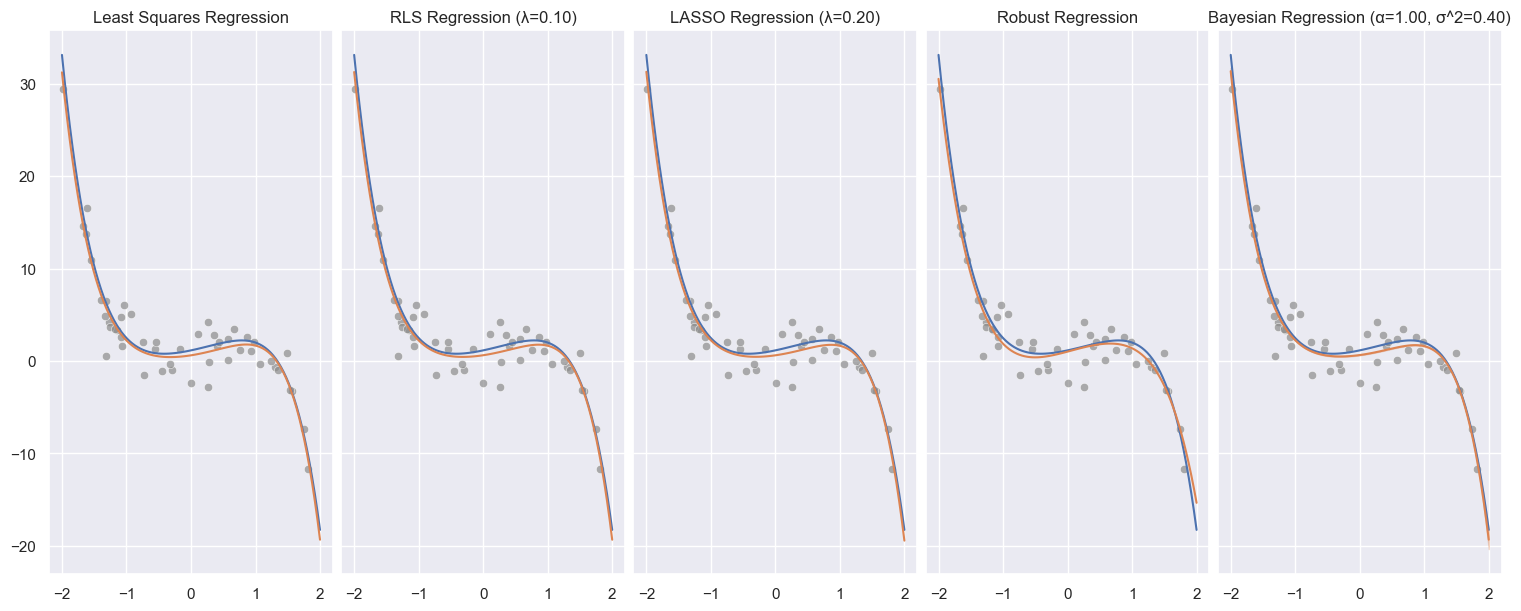

In [11]:
def fit_predict_plot(models, phi):
    fig, axs = plt.subplots(1, len(models), figsize=(len(models) * 3, 6), sharey=True, constrained_layout=True)
    for model, ax in zip(models, axs):
        model.phi = phi
        result = model.fit(X_sample, y_sample)    
        (y_poly_predict, std) = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        print(model.title)
        print(f"Estimated parameter:\n{result}")
        print(f"Mean squared error: {mse}")
        print("-" * 72)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)
        sns.scatterplot(x=X_sample.reshape((-1,)), y=y_sample, alpha=0.7, color=colors[7], ax=ax)
        ax.set_title(model.title)

models_1b = [LS(), RLS(l=0.1), LASSO(l=0.2), RR(), BR(alpha=1, sigma_2=0.4)]
fit_predict_plot(models_1b, phi=poly_5)

### (c) Smaller training data

/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


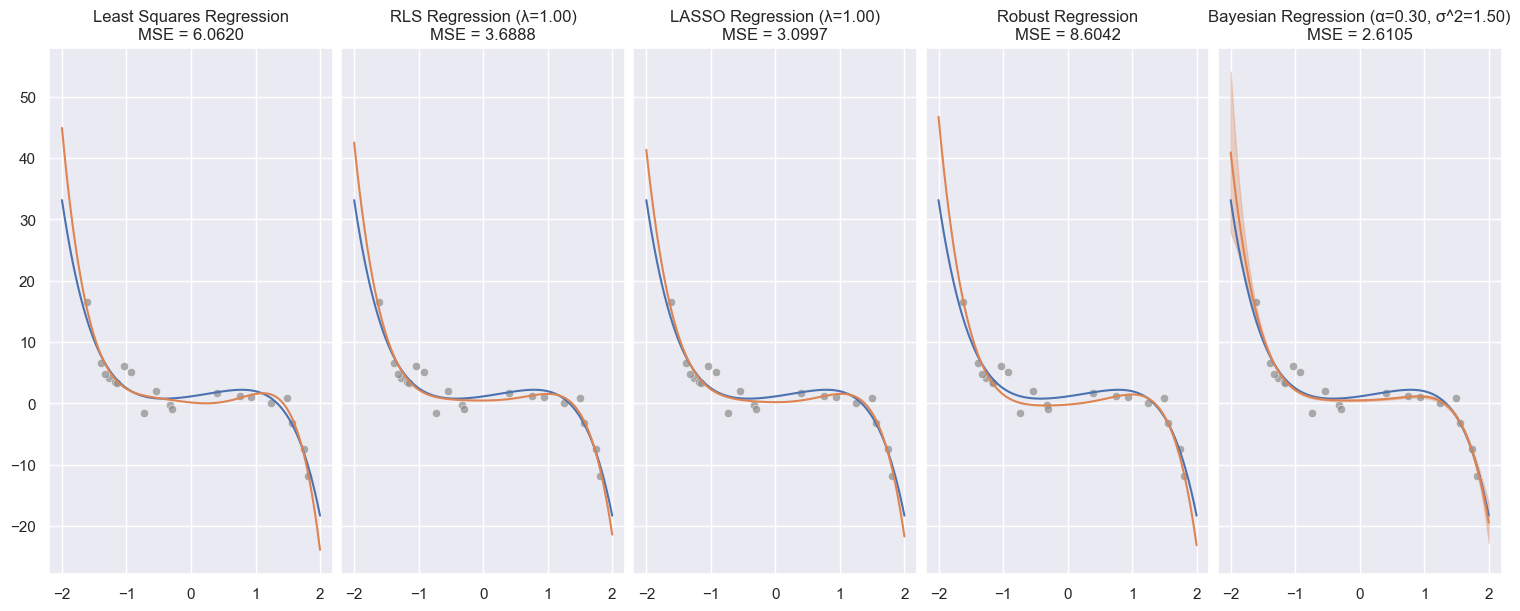

In [12]:
def fit_predict_plot_reduced_data(models, phi=poly_5, training_size=1, seed=12):
    n = y_sample.size
    rng = np.random.default_rng(seed)
    rand_idx = rng.permutation(n)[:math.ceil(n * training_size)]
    X_sample_subset = X_sample[:, rand_idx]
    y_sample_subset = y_sample[rand_idx]

    fig, axs = plt.subplots(1, len(models), sharey=True, figsize=(len(models) * 3, 6), constrained_layout=True)

    for model, ax in zip(models, axs):
        model.phi = phi
        result = model.fit(X_sample_subset, y_sample_subset)    
        y_poly_predict, std = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample_subset.reshape((-1,)), y=y_sample_subset, alpha=0.7, color=colors[7], ax=ax)

        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1c = [LS(), RLS(l=1), LASSO(l=1), RR(), BR(alpha=0.3, sigma_2=1.5)]
fit_predict_plot_reduced_data(models_1c, training_size=0.4, seed=12)

/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


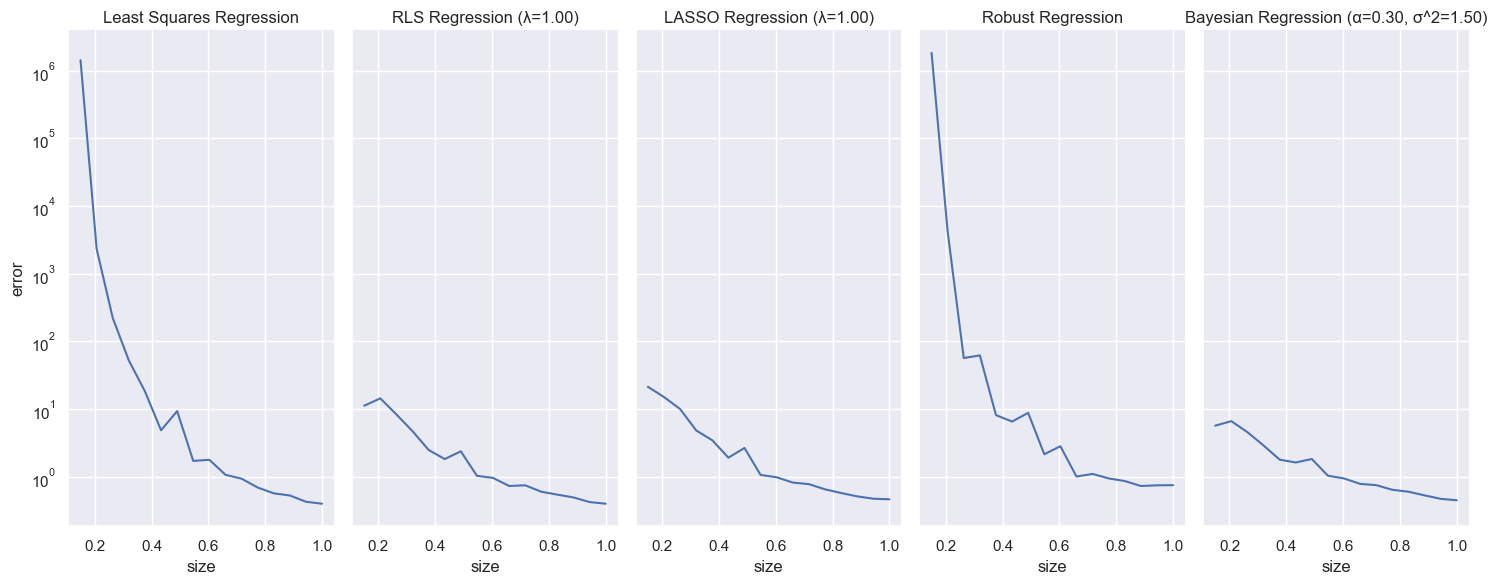

In [13]:
def error_vs_training_size(models, phi=poly_5, num_sizes=16, num_samples=5, seed=12):
    n = y_sample.size
    sizes = np.linspace(0.15, 1, num=num_sizes)
    rng = np.random.default_rng(seed)
    seeds = rng.integers(10*num_sizes*num_samples, size=(num_sizes, num_samples))

    def sample_mses(models, subset_size, seed):
        rng = np.random.default_rng(seed)
        rand_idx = rng.permutation(n)[:subset_size]
        X_sample_subset = X_sample[:, rand_idx]
        y_sample_subset = y_sample[rand_idx]

        mses = []
        for model in models:
            model.phi = phi
            result = model.fit(X_sample_subset, y_sample_subset)
            y_poly_predict, _ = model.predict(X_poly)
            mse = np.square(y_poly - y_poly_predict).mean()

            mses.append(mse)
        return mses

    # row 1: size, row 2: errors, row 3: model
    data = np.empty((3, 0))
    model_titles = np.array([model.title for model in models])
    for i, size in np.ndenumerate(sizes):
        subset_size = int(n * size) + 1
        # average MSE of each model at training_size=size based on multiple samples
        errors = np.zeros((1, len(models)))
        for run in range(num_samples):
            mses = sample_mses(models, subset_size, seeds[i[0], run])
            errors = np.vstack((errors, mses))
        mean_mses = errors.mean(axis=0)
        sample_result = np.vstack((
            np.full_like(mean_mses, size),
            mean_mses,
            np.arange(len(models)),
        ))
        data = np.hstack((data, sample_result))

    df = pd.DataFrame({
        "size": data[0, :],
        "error": data[1, :],
        "model": data[2, :].astype(int),
    })

    g = sns.relplot(
        data=df,
        x="size",
        y="error",
        col="model",
        kind="line",
        height=6,
        aspect=0.5,
    )
    g.set(yscale="log")
    for model, ax in zip(models, g.axes[0]):
        ax.set_title(model.title)

error_vs_training_size(models_1c, num_sizes=16, num_samples=50)

In the above experiment, for each specific training subset size, e.g., 0.5, we select a random subset of the training data of that size then fit the regression models to it for 50 times, then take the average mean squared error (MSE). In the end, we get a plot like above, where `size` indicates the proportion of the selected training data, and `error` is the average MSE of each model after repeat 50 times.

We see that when the amount of data is very low, i.e., around 30% smaller than the original training set, the best performing model is undoubtedly Bayesian regression, followed by RLS and LASSO regression, while least squares and robust regression performs very badly due to overfitting. When there are a decent amount of data, then all methods except robust regression perform equally well, with robust regression falling behind when the subset approaches the full original training data. Overall, the most robust method seems to be Bayesian regression.

### d) Outliers robustness

/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


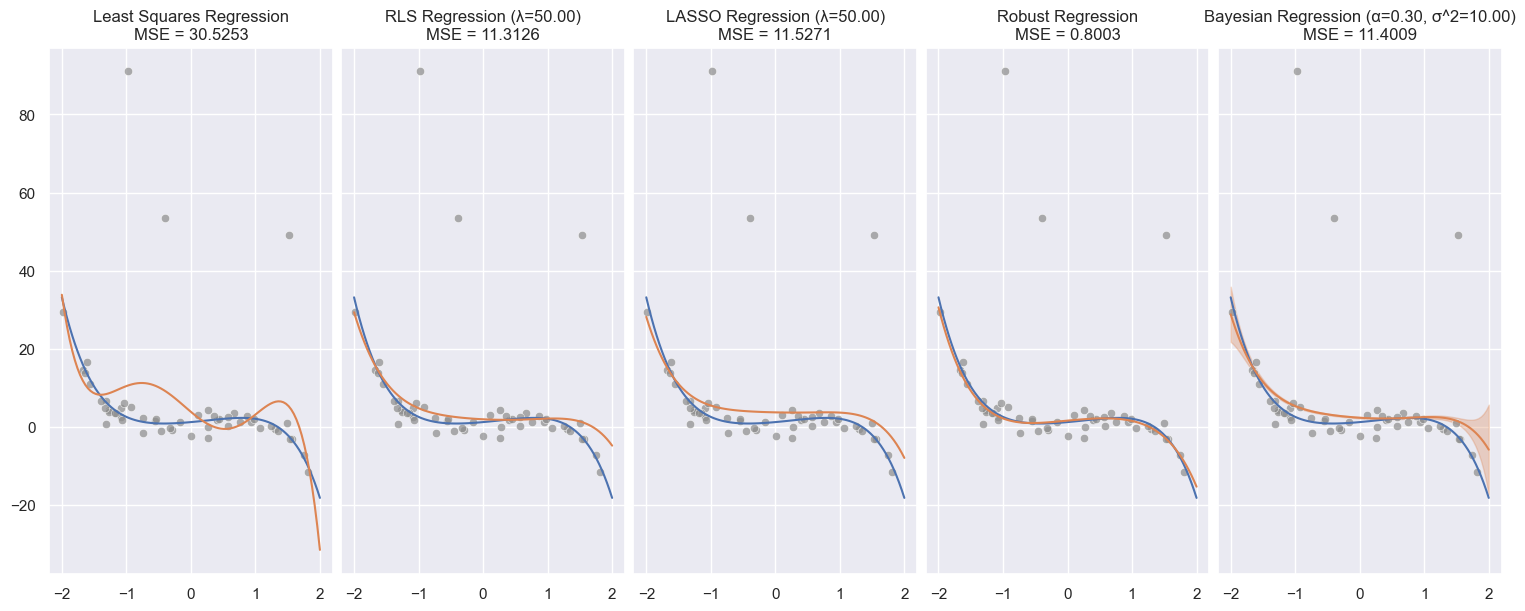

In [14]:
def fit_predict_plot_outliers(models, phi=poly_5, num_outliers=3, seed=12):
    rng = np.random.default_rng(seed)
    upper = abs(np.max(y_sample))
    qs = np.sort(rng.random(size=num_outliers))

    X_outlier = np.quantile(X_sample, qs, axis=1).T
    y_outlier = rng.uniform(low=1.5*upper+5, high=3*upper + 5, size=num_outliers)
    X_sample_outlier = np.hstack((X_sample, X_outlier))
    y_sample_outlier = np.hstack((y_sample, y_outlier))

    fig, axs = plt.subplots(1, len(models), figsize=(len(models) * 3, 6), sharey=True, constrained_layout=True)

    for model, ax in zip(models, axs):
        model.phi = phi
        result = model.fit(X_sample_outlier, y_sample_outlier)
        y_poly_predict, std = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample_outlier.reshape((-1,)), y=y_sample_outlier, alpha=0.7, color=colors[7], ax=ax)

        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1d = [LS(), RLS(l=50), LASSO(l=50), RR(), BR(alpha=0.3, sigma_2=10)]
fit_predict_plot_outliers(models_1d, num_outliers=3, seed=35)

In the presence of outliers, robust regression is the best method, with virtually no negative impact on its accuracy and precision. RLS, LASSO, and Bayesian regression are also capable of handling the case of outliers by tweaking their hyperparameters, specifically by
- choosing a large lambda to penalize the complexity of the estimator in the case of RLS and LASSO, and
- choosing a large sample variance to signify a higher possibility of outliers in the case of Bayesian regression.

Here, least squares regression performs the worst and is easily affected by outliers, even with just one of them.

### (e) Complex model

Least Squares Regression
[ -0.09937581   3.79351203   6.49122012 -10.74477383  -5.52167701
   8.63226351   0.6537136   -3.04579888   0.76354946   0.31028117
  -0.17513791]
------------------------------------------------------------------------
RLS Regression (λ=3.00)
[ 0.84208891  0.32357596  0.78369772 -0.40735401 -0.0073885  -0.29183431
 -0.29336061 -0.14217197  0.34445196 -0.00102968 -0.07224856]
------------------------------------------------------------------------
LASSO Regression (λ=0.50)
[ 5.20181208e-01  9.99149184e-01  2.65111278e+00 -1.52834537e+00
 -8.53522556e-01 -1.67747585e-05 -1.29899149e+00  7.02514621e-03
  1.05514836e+00 -5.05913705e-02 -1.85751166e-01]
------------------------------------------------------------------------
Robust Regression
[ -0.77214121   3.0252024   13.14885338  -7.57592575 -19.78002561
   5.64238377  12.19446275  -2.16419757  -3.15723807   0.24538581
   0.29052235]
------------------------------------------------------------------------
Bayesi

/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


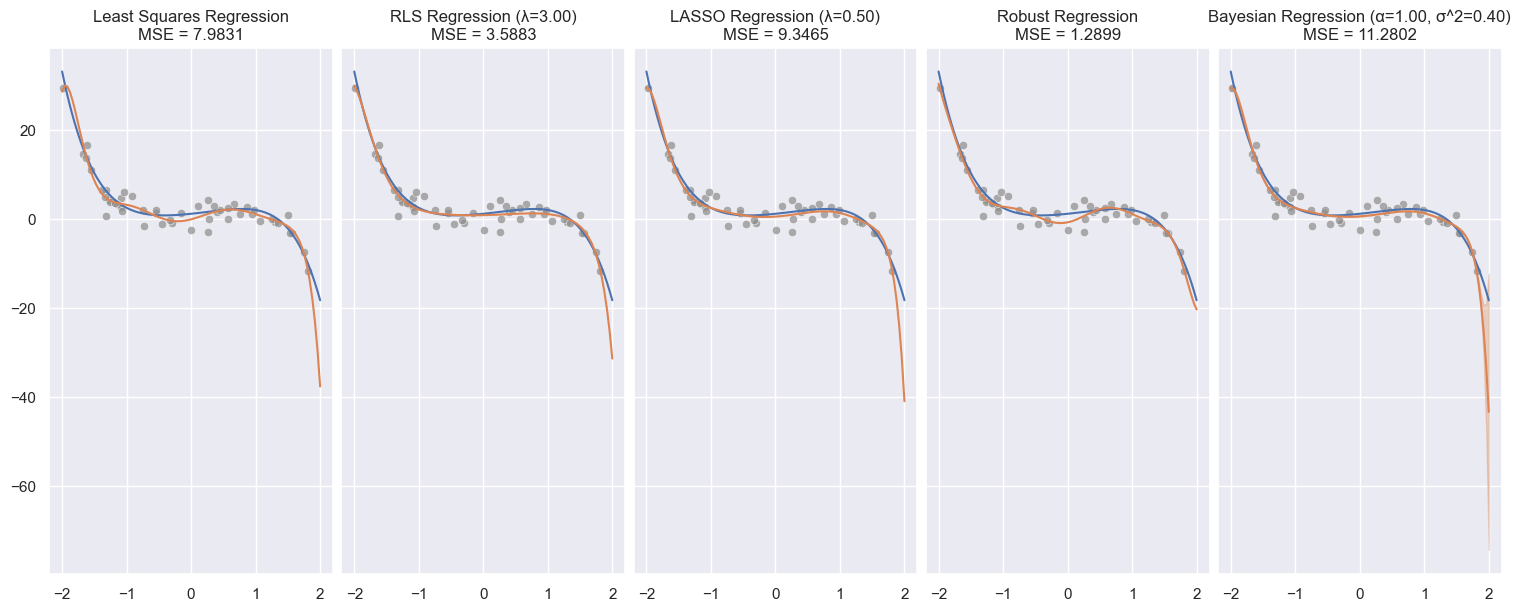

In [15]:
def fit_predict_plot_poly_10(models):
    poly_10 = lambda x: x[0]**np.array(range(10+1))

    fig, axs = plt.subplots(1, len(models), figsize=(len(models) * 3, 6), sharey=True, constrained_layout=True)

    for model, ax in zip(models, axs):
        model.phi = poly_10
        result = model.fit(X_sample, y_sample)
        y_poly_predict, std = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        print(model.title)
        print(result)
        print("-" * 72)

        X_poly_1d = X_poly.reshape((-1,))
        colors = sns.color_palette()

        # test dataset
        sns.lineplot(x=X_poly_1d, y=y_poly, color=colors[0], ax=ax)
        sns.lineplot(x=X_poly_1d, y=y_poly_predict, color=colors[1], ax=ax)
        if std is not None:
            ax.fill_between(X_poly_1d, y_poly_predict - std, y_poly_predict + std, color=colors[1], alpha=0.3)

        # sample dataset
        sns.scatterplot(x=X_sample.reshape((-1,)), y=y_sample, alpha=0.7, color=colors[7], ax=ax)

        ax.set_title(f"{model.title}\nMSE = {mse:.4f}")

models_1e = [LS(), RLS(l=3), LASSO(l=0.5), RR(), BR(alpha=1, sigma_2=0.4)]
fit_predict_plot_poly_10(models_1e)

From the graph and the estimated parameter, we see that least squares and robust regression exhibit the highest degree of overfitting a complex model to the data. Bayesian regression also suffers somewhat from this problem, while LASSO and RLS regression are the most resistant to overfitting.

## Part 2: Counting people

In [16]:
count_path = "PA-1-data-text/count_data_"
y_mean = read_input(f"{count_path}ym.txt")
X_train = read_input(f"{count_path}trainx.txt", atleast_2d=True)
y_train = read_input(f"{count_path}trainy.txt")
X_test = read_input(f"{count_path}testx.txt", atleast_2d=True)
y_test = read_input(f"{count_path}testy.txt")

Least Squares Regression
Mean absolute error: 1.3584
Mean squared error: 3.1028
----------------------------------------
RLS Regression (λ=0.50)
Mean absolute error: 1.2795
Mean squared error: 2.6504
----------------------------------------
LASSO Regression (λ=5.00)
Mean absolute error: 1.2565
Mean squared error: 2.4645
----------------------------------------
Robust Regression
Mean absolute error: 1.3646
Mean squared error: 3.1190
----------------------------------------
Bayesian Regression (α=1.50, σ^2=1.20)
Mean absolute error: 1.2777
Mean squared error: 2.6157
----------------------------------------


/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


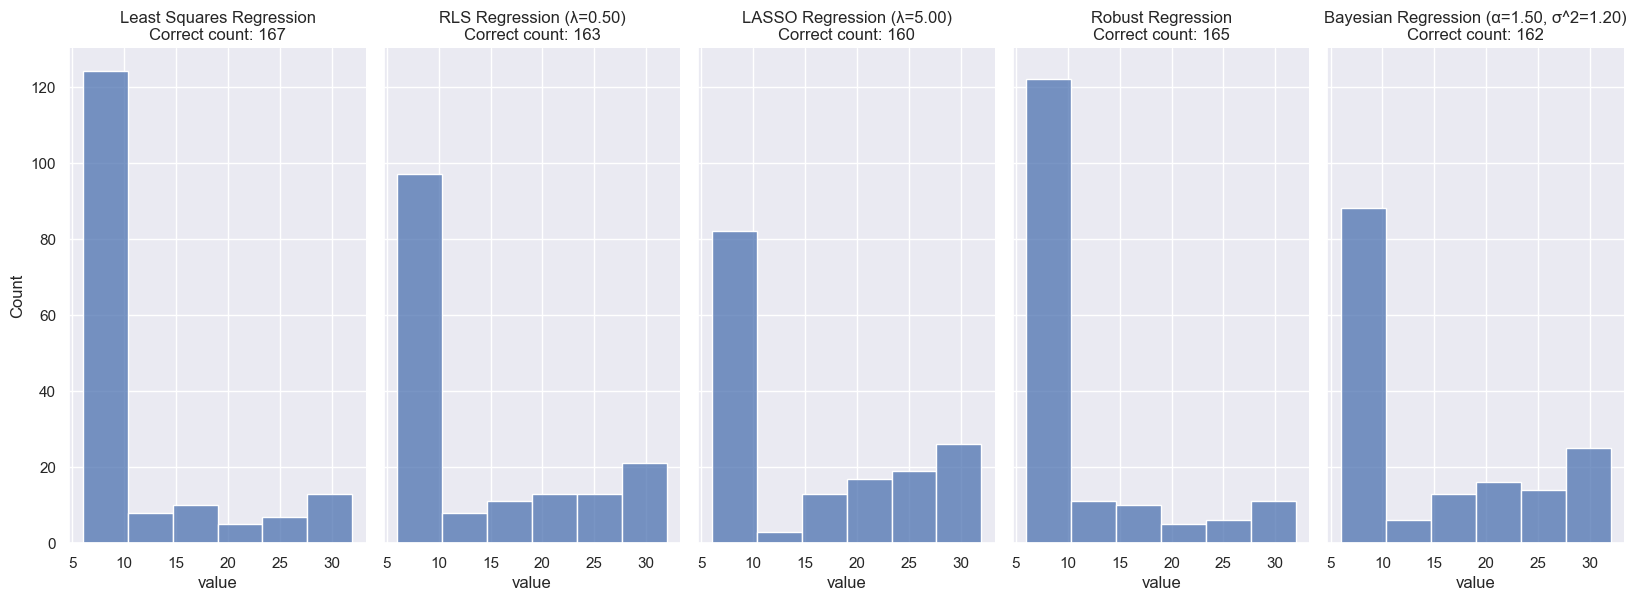

In [17]:
def fit_predict_plot_count(models, phi):
    df = pd.DataFrame()
    correct_count = []
    for model in models:
        model.phi = phi
        result = model.fit(X_train, y_train)
        y_test_predict, std = model.predict(X_test)
        mae = np.abs(y_test - y_test_predict).mean()
        mse = np.square(y_test - y_test_predict).mean()

        print(model.title)
        print(f"Mean absolute error: {mae:.4f}")
        print(f"Mean squared error: {mse:.4f}")
        print("-" * 40)

        y_test_int = y_test + y_mean
        y_test_predict_int = np.round(y_test_predict + y_mean)

        correct_predicts = y_test_int[y_test_int == y_test_predict_int]
        correct_count.append(correct_predicts.size)
        df_correct_predict = pd.DataFrame({
            "value": correct_predicts,
            "model": [model.title] * correct_predicts.size,
        })
        df = pd.concat([df, df_correct_predict], axis=0)

    g = sns.displot(df, x="value", binwidth=4, col="model", height=6, aspect=0.55)
    for ax, model, count in zip(g.axes[0], models, correct_count):
        ax.set_title(f"{model.title}\nCorrect count: {count}")

models_2a = [LS(), RLS(l=0.5), LASSO(l=5), RR(), BR(alpha=1.5, sigma_2=1.2)]
fit_predict_plot_count(models_2a, phi=lambda x: x)

### 2(b) Alternative feature transformation

Least Squares Regression
Mean absolute error: 1.3267
Mean squared error: 2.9236
----------------------------------------
RLS Regression (λ=0.50)
Mean absolute error: 1.2088
Mean squared error: 2.4278
----------------------------------------
LASSO Regression (λ=5.00)
Mean absolute error: 1.1886
Mean squared error: 2.3452
----------------------------------------
Robust Regression
Mean absolute error: 1.3079
Mean squared error: 2.8981
----------------------------------------
Bayesian Regression (α=1.50, σ^2=1.20)
Mean absolute error: 1.2092
Mean squared error: 2.4405
----------------------------------------


/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


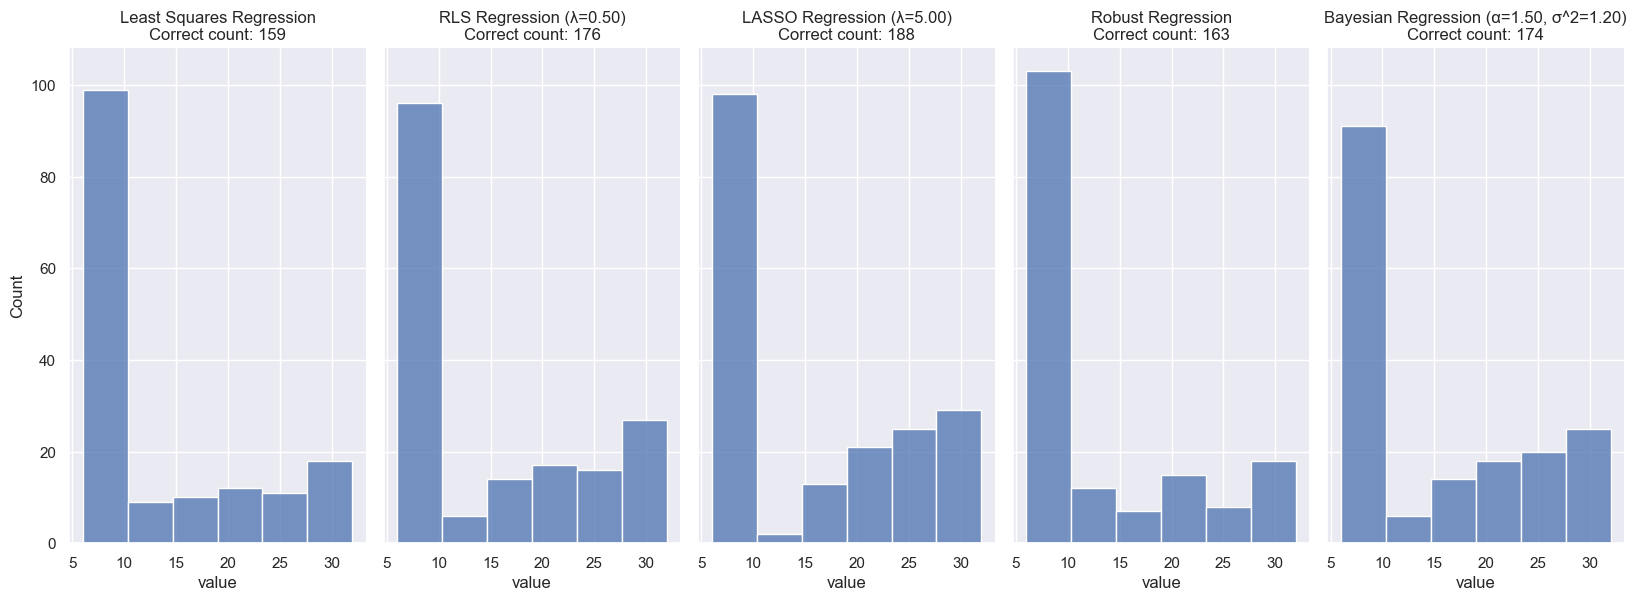

In [18]:
# maps (x1, ..., x9) to (x1, ..., x9, x1^2, ..., x9^2)
poly_2 = lambda x: np.concatenate((x, x**2))
fit_predict_plot_count(models_2a, phi=poly_2)

Least Squares Regression
Mean absolute error: 1.3367
Mean squared error: 3.0776
----------------------------------------
RLS Regression (λ=3.00)
Mean absolute error: 1.2086
Mean squared error: 2.5083
----------------------------------------
LASSO Regression (λ=3.00)
Mean absolute error: 1.2087
Mean squared error: 2.5389
----------------------------------------
Robust Regression
Mean absolute error: 1.2756
Mean squared error: 2.9125
----------------------------------------
Bayesian Regression (α=1.00, σ^2=2.50)
Mean absolute error: 1.2108
Mean squared error: 2.5264
----------------------------------------


/Users/hai/Repos/cs5487/pa-1/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


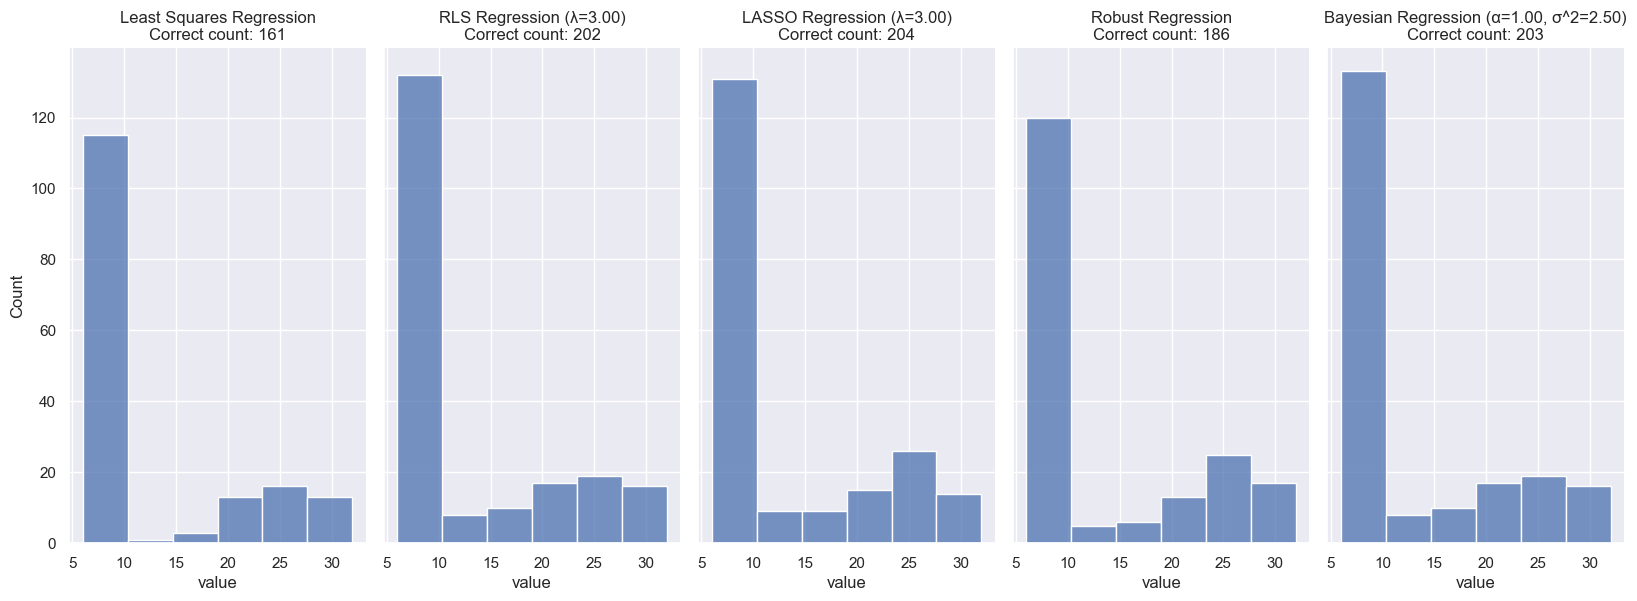

In [19]:
models_2b = [LS(), RLS(l=3), LASSO(l=3), RR(), BR(alpha=1, sigma_2=2.5)]
phi = lambda x: np.concatenate((
    x,
    x**2,
    x**3 / 2,
    np.ceil(x),
    np.sin(x),
    np.exp(x[0] * x[1:]),
))
fit_predict_plot_count(models_2b, phi=phi)